# Working with JSON, Arrays, and Structs in BigQuery

GSP416

https://www.cloudskillsboost.google/focuses/3696?parent=catalog

### Overview

BigQuery is Google's fully managed, NoOps, low cost analytics database. With BigQuery you can query terabytes and terabytes of data without having any infrastructure to manage or needing a database administrator. BigQuery uses SQL and can take advantage of the pay-as-you-go model. BigQuery allows you to focus on analyzing data to find meaningful insights.

In this lab you will work in-depth with semi-structured data (ingesting JSON, Array data types) inside of BigQuery. Denormalizing your schema into a single table with nested and repeated fields can yield performance improvements, but the SQL syntax for working with array data can be tricky. You will practice loading, querying, troubleshooting, and unnesting various semi-structured datasets.

# Practice working with Arrays in SQL

In [ ]:
#standardSQL
SELECT
['raspberry', 'blackberry', 'strawberry', 'cherry'] AS fruit_array

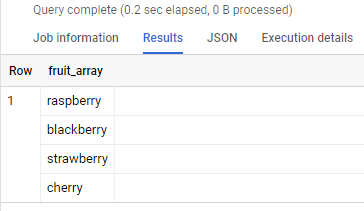

In [ ]:
#standardSQL
SELECT
['raspberry', 'blackberry', 'strawberry', 'cherry', 1234567] AS fruit_array

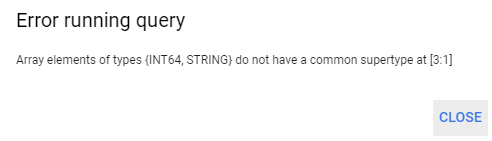

Why did you get this error?
- Data in an array [ ] must all be the same type.
- Arrays can only share one data type (all strings, all numbers).

In [ ]:
#standardSQL
SELECT person, fruit_array, total_cost FROM `data-to-insights.advanced.fruit_store`;

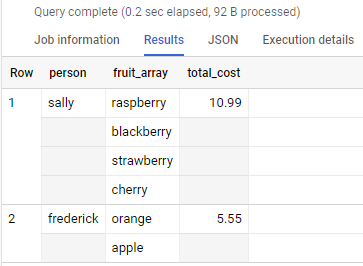

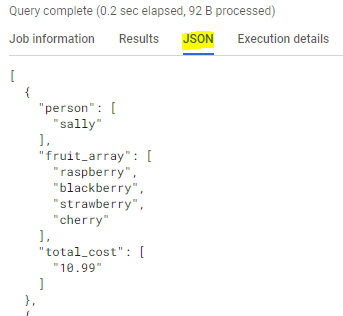

# Loading semi-structured JSON into BigQuery


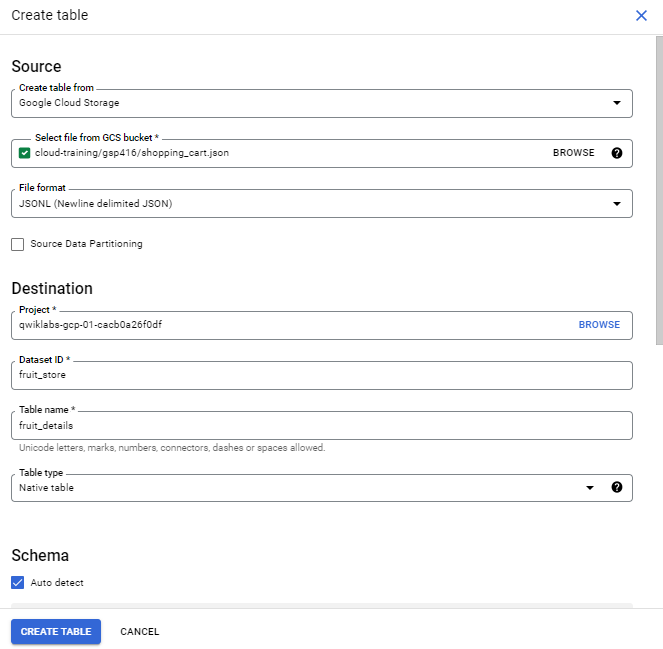

In the schema, note that `fruit_array` is marked as `REPEATED` which means it's an array.

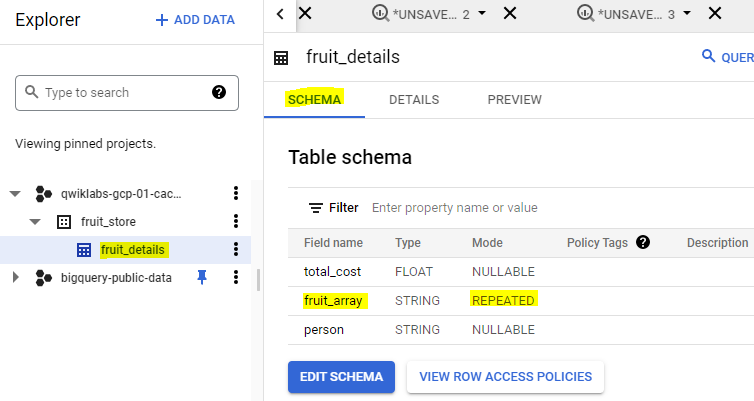

### Recap

- BigQuery natively supports arrays
- Array values must share a data type
- Arrays are called `REPEATED` fields in BigQuery


# Creating your own arrays with ARRAY_AGG()

Don't have arrays in your tables already? You can create them!

In [ ]:
SELECT
  fullVisitorId,
  date,
  v2ProductName,
  pageTitle
  FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
ORDER BY date

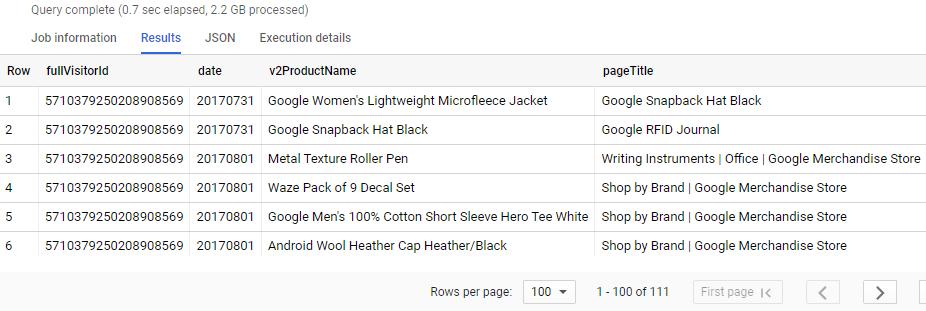

Now, use the `ARRAY_AGG()` function to aggregate our string values into an array.

In [ ]:
SELECT
  fullVisitorId,
  date,
  ARRAY_AGG(v2ProductName) AS products_viewed,
  ARRAY_AGG(pageTitle) AS pages_viewed
  FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
GROUP BY fullVisitorId, date
ORDER BY date

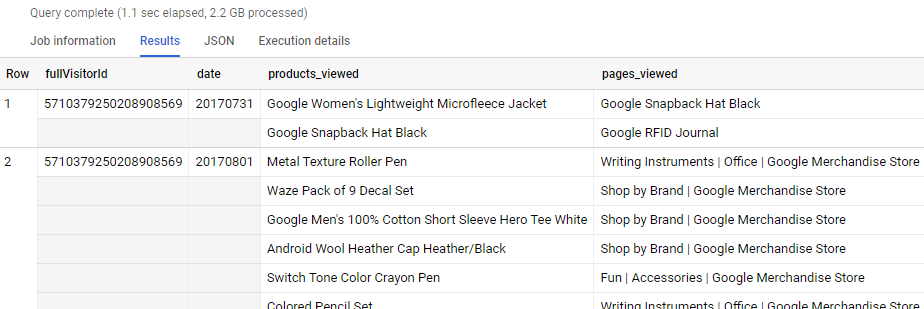

How many rows are returned?

Answer: 2 - one for each day.

Next, use the `ARRAY_LENGTH()` function to count the number of pages and products that were viewed.

In [ ]:
SELECT
  fullVisitorId,
  date,
  ARRAY_AGG(v2ProductName) AS products_viewed,
  ARRAY_LENGTH(ARRAY_AGG(v2ProductName)) AS num_products_viewed,
  ARRAY_AGG(pageTitle) AS pages_viewed,
  ARRAY_LENGTH(ARRAY_AGG(pageTitle)) AS num_pages_viewed
  FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
GROUP BY fullVisitorId, date
ORDER BY date

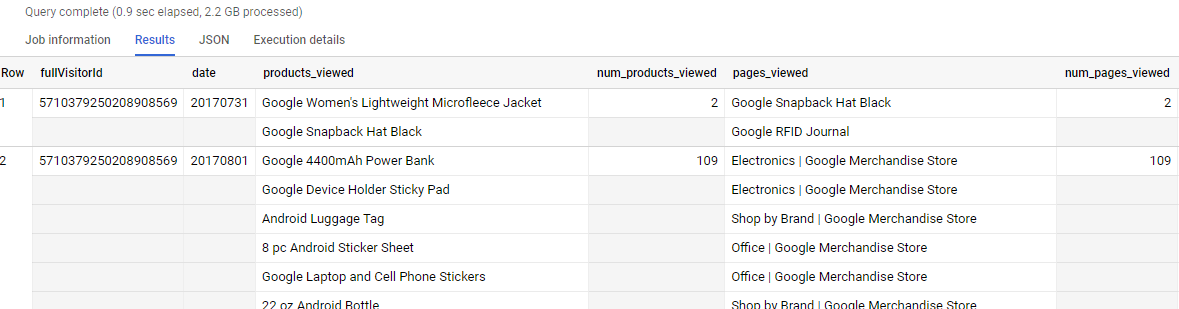

Next, deduplicate the pages and products so you can see how many unique products were viewed by adding `DISTINCT` to `ARRAY_AGG()`.

In [ ]:
SELECT
  fullVisitorId,
  date,
  ARRAY_AGG(DISTINCT v2ProductName) AS products_viewed,
  ARRAY_LENGTH(ARRAY_AGG(DISTINCT v2ProductName)) AS distinct_products_viewed,
  ARRAY_AGG(DISTINCT pageTitle) AS pages_viewed,
  ARRAY_LENGTH(ARRAY_AGG(DISTINCT pageTitle)) AS distinct_pages_viewed
  FROM `data-to-insights.ecommerce.all_sessions`
WHERE visitId = 1501570398
GROUP BY fullVisitorId, date
ORDER BY date

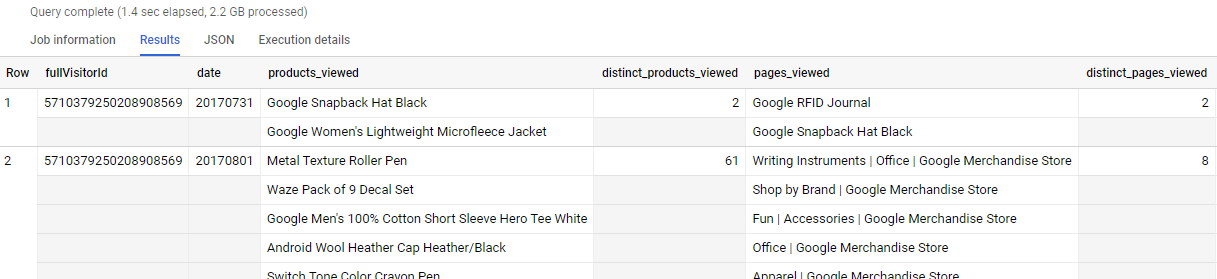

### Recap

You can do some pretty useful things with arrays like:

- finding the number of elements with `ARRAY_LENGTH(<array>)`
- deduplicating elements with `ARRAY_AGG(DISTINCT <field>)`
- ordering elements with `ARRAY_AGG(<field> ORDER BY <field>)`
- limiting `ARRAY_AGG(<field> LIMIT 5)`

# Querying datasets that already have ARRAYs

The BigQuery Public Dataset for Google Analytics `bigquery-public-data.google_analytics_sample` has many more fields and rows than our course dataset `data-to-insights.ecommerce.all_sessions`. More importantly, it already stores field values like products, pages, and transactions natively as ARRAYs.

In [ ]:
SELECT
  *
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE visitId = 1501570398

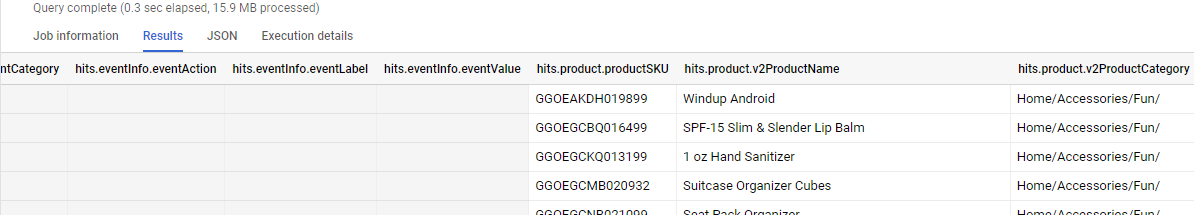

In [ ]:
SELECT
  visitId,
  hits.page.pageTitle
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE visitId = 1501570398

You will get an error: `Cannot access field page on a value with type ARRAY<STRUCT<hitNumber INT64, time INT64, hour INT64, ...>> at [3:8]`

Before you can query `REPEATED` fields (arrays) normally, you must first break the arrays back into rows.

For example, the array for `hits.page.pageTitle` is stored currently as a single row like:

['homepage','product page','checkout']

and it needs to be

['homepage',

'product page',

'checkout']

How do you do that with SQL?

Answer: Use the `UNNEST()` function on your array field:

In [ ]:
SELECT DISTINCT
  visitId,
  h.page.pageTitle
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`,
UNNEST(hits) AS h
WHERE visitId = 1501570398
LIMIT 10

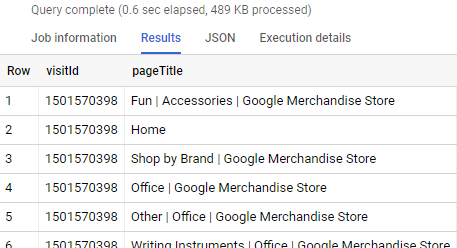

We'll cover `UNNEST()` more in detail later but for now just know that:
- You need to `UNNEST()` arrays to bring the array elements back into rows.
- `UNNEST()` always follows the table name in your `FROM` clause (think of it conceptually like a pre-joined table)

# Introduction to STRUCTs

You may have wondered why the field alias `hit.page.pageTitle` looks like three fields in one separated by periods. Just as ARRAY values give you the flexibility to go deep into the granularity of your fields, another data type allows you to go wide in your schema by grouping related fields together. That SQL data type is the [STRUCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types#struct-type) data type.

The easiest way to think about a STRUCT is to consider it conceptually like a separate table that is already pre-joined into your main table.

A STRUCT can have:
- one or many fields in it
- the same or different data types for each field
- it's own alias

Sounds just like a table right?

### Explore a dataset with STRUCTs

To open the bigquery-public-data dataset right click on this [link](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=google_analytics_sample&t=ga_sessions_20170801&page=table) and copy the URL. Open a a new incognito tab, or use a different browser, and paste in the copied URL.

Click open `bigquery-public-data`

Find and open `google_analytics_sample`

Click the `ga_sessions` table

As you can imagine, there is an incredible amount of website session data stored for a modern ecommerce website.

The main advantage of having 32 STRUCTs in a single table is it allows you to run queries like this one without having to do any JOINs:

In [ ]:
SELECT
  visitId,
  totals.*,
  device.*
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE visitId = 1501570398
LIMIT 10

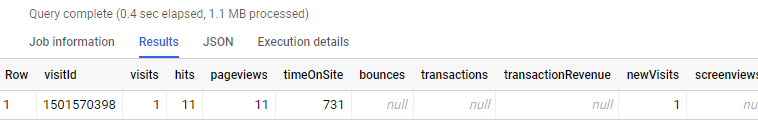

Note: The `.*` syntax tells BigQuery to return all fields for that `STRUCT` (much like it would if `totals.*` was a separate table we joined against)

Storing your large reporting tables as STRUCTs (pre-joined "tables") and ARRAYs (deep granularity) allows you to:

- gain significant performance advantages by avoiding 32 table JOINs
- get granular data from ARRAYs when you need it but not be punished if you don't (BigQuery stores each column individually on disk)
- have all the business context in one table as opposed to worrying about JOIN keys and which tables have the data you need

# Practice with STRUCTs and ARRAYs

The next dataset will be lap times of runners around the track. Each lap will be called a "split".

With this query, try out the `STRUCT` syntax and note the different field types within the struct container:

In [ ]:
#standardSQL
SELECT STRUCT("Rudisha" as name, 23.4 as split) as runner

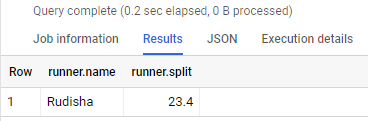

What do you notice about the field aliases? Since there are fields nested within the struct (`name` and `split` are a subset of `runner`) you end up with a dot notation.

What if the `runner` has multiple split times for a single race (like time per lap)?

How could you have multiple split times within a single record? Hint: the splits all have the same numeric datatype.

Answer: Store each split time as an element in an `ARRAY` of splits.

In [ ]:
#standardSQL
SELECT STRUCT("Rudisha" as name, [23.4, 26.3, 26.4, 26.1] as splits) AS runner

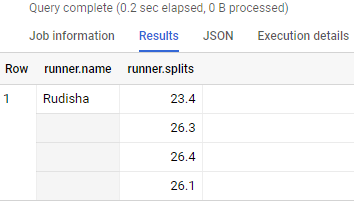

### To recap:

- Structs are containers that can have multiple field names and data types nested inside.

- An arrays can be one of the field types inside of a Struct (as shown above with the splits field).

# Practice ingesting JSON data

Create a new dataset titled `racing`.

Create a new table titled `race_results`. Click on `racing` dataset and click `Create table`.

Ingest this Cloud Storage JSON file:

`gs://data-insights-course/labs/optimizing-for-performance/race_results.json`

- **Source**: select **Cloud Storage** under **Create table from** dropdown.

- **Select file from Cloud Storage bucket**: gs://data-insights-course/labs/optimizing-for-performance/race_results.json

- **File format**: JSONL (Newline delimited JSON)

- In **Schema**, click on **Edit as text** slider and add the following:

In [ ]:
[
    {
        "name": "race",
        "type": "STRING",
        "mode": "NULLABLE"
    },
    {
        "name": "participants",
        "type": "RECORD",
        "mode": "REPEATED",
        "fields": [
            {
                "name": "name",
                "type": "STRING",
                "mode": "NULLABLE"
            },
            {
                "name": "splits",
                "type": "FLOAT",
                "mode": "REPEATED"
            }
        ]
    }
]

Click `Create table`.

After the load job is successful, preview the schema for the newly created table:

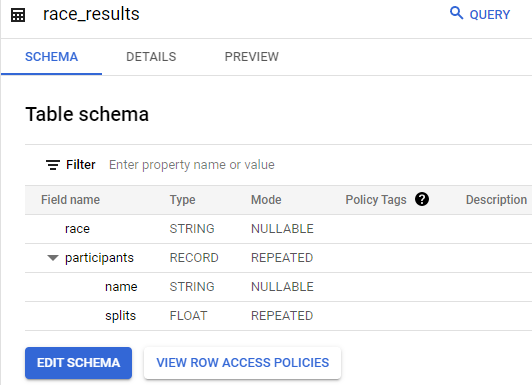

Which field is the `STRUCT`? How do you know?

- The `participants` field is the `STRUCT` because it is of type `RECORD`

Which field is the `ARRAY`?

- The `participants.splits` field is an array of floats inside of the parent `participants` struct. It has a `REPEATED` Mode which indicates an array. Values of that array are called nested values since they are multiple values inside of a single field.

# Practice querying nested and repeated fields

Let's see all of our racers for the 800 Meter race.

In [ ]:
#standardSQL
SELECT * FROM racing.race_results

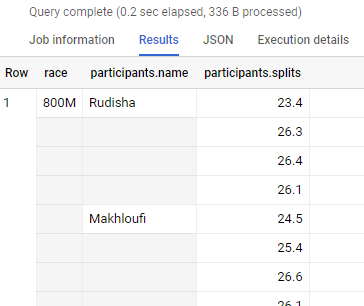

What if you wanted to list the name of each runner and the type of race?

Run the below schema and see what happens:

In [ ]:
#standardSQL
SELECT race, participants.name
FROM racing.race_results

Error: `Cannot access field name on a value with type ARRAY<STRUCT<name STRING, splits ARRAY<FLOAT64>>>> at [2:27]`

Much like forgetting to `GROUP BY` when you use aggregation functions, here there are two different levels of granularity. One row for the race and three rows for the participants names. So how do you change this...

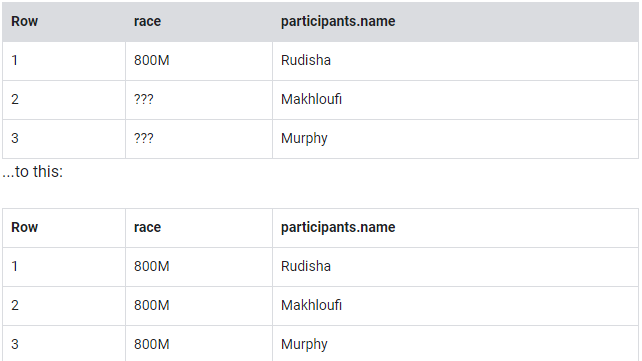

In traditional relational SQL, if you had a races table and a participants table what would you do to get information from both tables? You would JOIN them together. Here the participant STRUCT (which is conceptually very similar to a table) is already part of your races table but is not yet correlated correctly with your non-STRUCT field "race".

Can you think of what two word SQL command you would use to correlate the 800M race with each of the racers in the first table?

Answer: CROSS JOIN

Great! Now try running this:

In [ ]:
#standardSQL
SELECT race, participants.name
FROM racing.race_results
CROSS JOIN
participants  # this is the STRUCT (it is like a table within a table)

Error: `Table name "participants" missing dataset while no default dataset is set in the request.`

Even though the participants `STRUCT` is like a table, it is still technically a field in the `racing.race_results` table.

Add the dataset name to the query:

In [ ]:
#standardSQL
SELECT race, participants.name
FROM racing.race_results
CROSS JOIN
race_results.participants # full STRUCT name

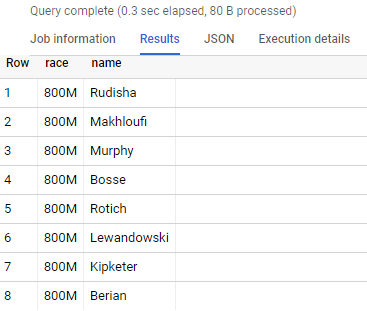

Wow! You've successfully listed all of the racers for each race!

You can simplify the last query by:
- Adding an alias for the original table
- Replacing the words "CROSS JOIN" with a comma (a comma implicitly cross joins)

This will give you the same query result:

In [ ]:
#standardSQL
SELECT race, participants.name
FROM racing.race_results AS r, r.participants

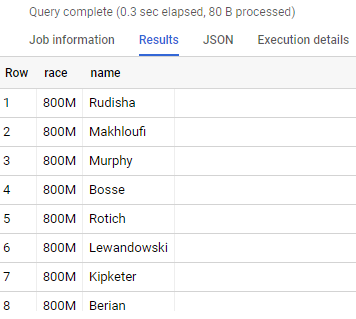

If you have more than one race type (800M, 100M, 200M), wouldn't a `CROSS JOIN` just associate every racer name with every possible race like a cartesian product?

Answer: No. This is a correlated cross join which only unpacks the elements associated with a single row. For a greater discussion, see [working with ARRAYs and STRUCTs](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#flattening-arrays).

### Recap of STRUCTs:

- A SQL `STRUCT` is simply a container of other data fields which can be of different data types. The word struct means data structure. Recall the example from earlier:

- `STRUCT(``"Rudisha" as name, [23.4, 26.3, 26.4, 26.1] as splits``)`` AS runner`

- STRUCTs are given an alias (like runner above) and can conceptually be thought of as a table inside of your main table.

- STRUCTs (and ARRAYs) must be unpacked before you can operate over their elements. Wrap an `UNNEST()` around the name of the struct itself or the struct field that is an array in order to unpack and flatten it.

# Lab Question: STRUCT()

Answer the below questions using the `racing.race_results` table you created previously.

Task: Write a query to `COUNT` how many racers were there in total.

Hint: Remember you will need to cross join in your struct name as an additional data source after the `FROM`.

In [ ]:
#standardSQL
SELECT COUNT(p.name) AS racer_count
FROM racing.race_results AS r, UNNEST(r.participants) AS p

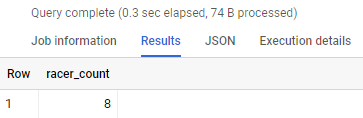

# Lab Question: Unpacking ARRAYs with UNNEST()

Write a query that will list the total race time for racers whose names begin with `R`. 

Order the results with the fastest total time first. 

Use the `UNNEST()` operator.

Hint: You will need to unpack both the struct and the array within the struct as data sources after your `FROM` clause. Be sure to use aliases where appropriate.

In [ ]:
#standardSQL
SELECT
  p.name,
  SUM(split_times) as total_race_time
FROM racing.race_results AS r
, UNNEST(r.participants) AS p
, UNNEST(p.splits) AS split_times
WHERE p.name LIKE 'R%'
GROUP BY p.name
ORDER BY total_race_time ASC;

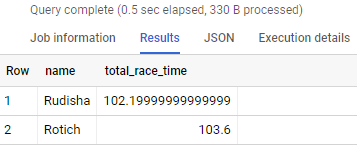

# Filtering within ARRAY values

You happened to see that the fastest lap time recorded for the 800 M race was 23.2 seconds, but you did not see which runner ran that particular lap. Create a query that returns that result.

In [ ]:
#standardSQL
SELECT
  p.name,
  split_time
FROM racing.race_results AS r
, UNNEST(r.participants) AS p
, UNNEST(p.splits) AS split_time
WHERE split_time = 23.2;

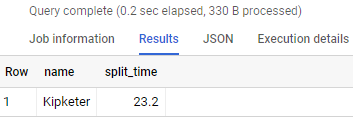